In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


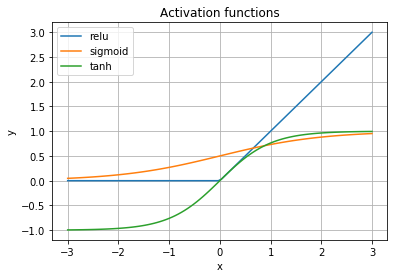

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset.

In [3]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    #############################################################################                          #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    train_data = []
    train_label = []
    file_path = './data/cifar-10-batches-py/data_batch_'
    for i in range(1,6):
        file_batch=file_path+str(i)
        data, label = unpickle(file_batch)
        train_data.extend(data)
        train_label.extend(label)
    train_np = np.array(train_data).reshape(len(train_data),3,32,32).transpose([0, 2, 3, 1])
    label_np = np.array(train_label)
    return train_np[:49000],label_np[:49000],train_np[49000:],label_np[49000:]


def load_test_data():   
    #############################################################################                           #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    file_path = './data/cifar-10-batches-py/test_batch'
    data, label = unpickle(file_path)
    test_data = np.array(data).reshape(len(data),3,32,32).transpose([0, 2, 3, 1])
    test_label = np.array(label)
    return test_data, test_label


# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [4]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
    #W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def FC(input, inp_neurons, out_neurons):
    #W = tf.get_variable('w',[inp_neurons,out_neurons], tf.float32, tf.random_normal_initializer(0.0, 0.02))
    W = tf.get_variable('w',[inp_neurons,out_neurons], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', [out_neurons], initializer=tf.constant_initializer(0.0))
    return tf.matmul(input, W) + b

def Normalization(input):
    return tf.nn.local_response_normalization(input,
                                              alpha=1e-4,
                                              beta=0.75,
                                              depth_radius=4,
                                              bias=1.0)


## Sample convolutional nueral network

In [5]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.contrib.layers.flatten(self.pool2)     
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = FC(self.flat, 4096, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = FC(self.relu3, 384, 10)            
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        self.is_train = None
        self.keep_prob = None

    def _build_optimizer(self):
        self.global_step = tf.Variable(0, trainable=False)
        self.initial_lr = 5e-4
        self.lr = tf.train.exponential_decay(self.initial_lr, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.initial_lr).minimize(self.loss_op, global_step=self.global_step)

        
    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))     


    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)

        
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]


                feed_dict = {self.X: X_, self.Y:Y_}                

                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            loss_hist_ = losses[10::100] # sparse the curve a bit
            plt.plot(loss_hist_, '-o')
            plt.xlabel('Iteration')
                

            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            accuracies_ = accuracies#[1::100]
            plt.plot(accuracies_, '-o', label='Training')
            plt.plot([0.5] * len(accuracies), 'k--')
            plt.xlabel('Epoch')
            plt.legend(loc='lower right')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            feed_dict = {self.X:X_, self.Y:Y_}

            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 77.043, accuracy = 0.070
iteration (50): loss = 2.010, accuracy = 0.227
iteration (100): loss = 1.766, accuracy = 0.359
iteration (150): loss = 1.738, accuracy = 0.328
iteration (200): loss = 1.710, accuracy = 0.438
iteration (250): loss = 1.631, accuracy = 0.438
iteration (300): loss = 1.525, accuracy = 0.422
iteration (350): loss = 1.493, accuracy = 0.438


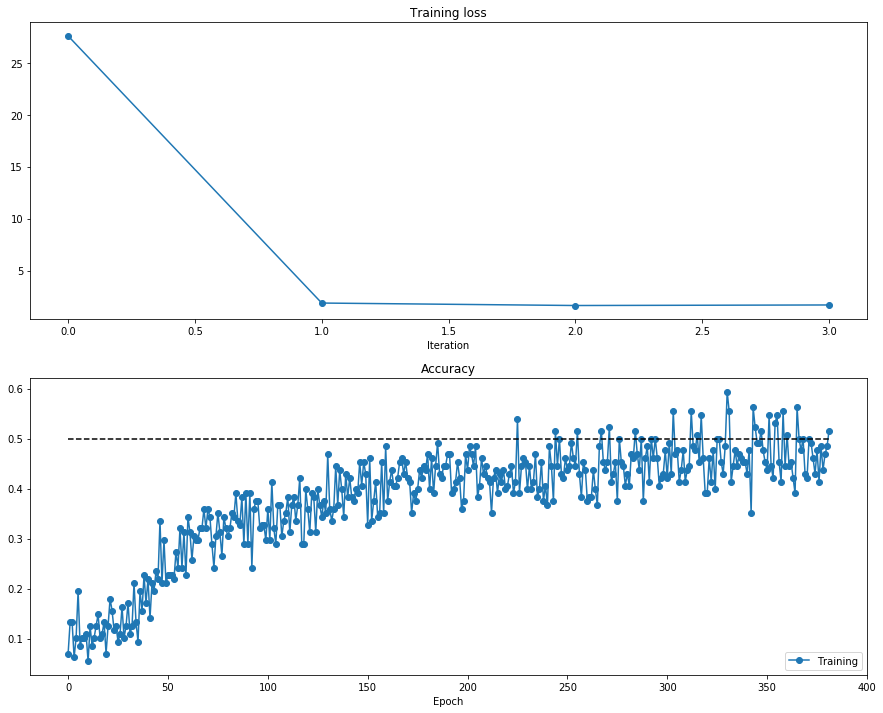

validation for epoch 0
-  epoch 0: validation accuracy = 0.498
train for epoch 1
iteration (400): loss = 1.401, accuracy = 0.508
iteration (450): loss = 1.364, accuracy = 0.500
iteration (500): loss = 1.398, accuracy = 0.484
iteration (550): loss = 1.282, accuracy = 0.555
iteration (600): loss = 1.377, accuracy = 0.523
iteration (650): loss = 1.331, accuracy = 0.500
iteration (700): loss = 1.142, accuracy = 0.602
iteration (750): loss = 1.136, accuracy = 0.594


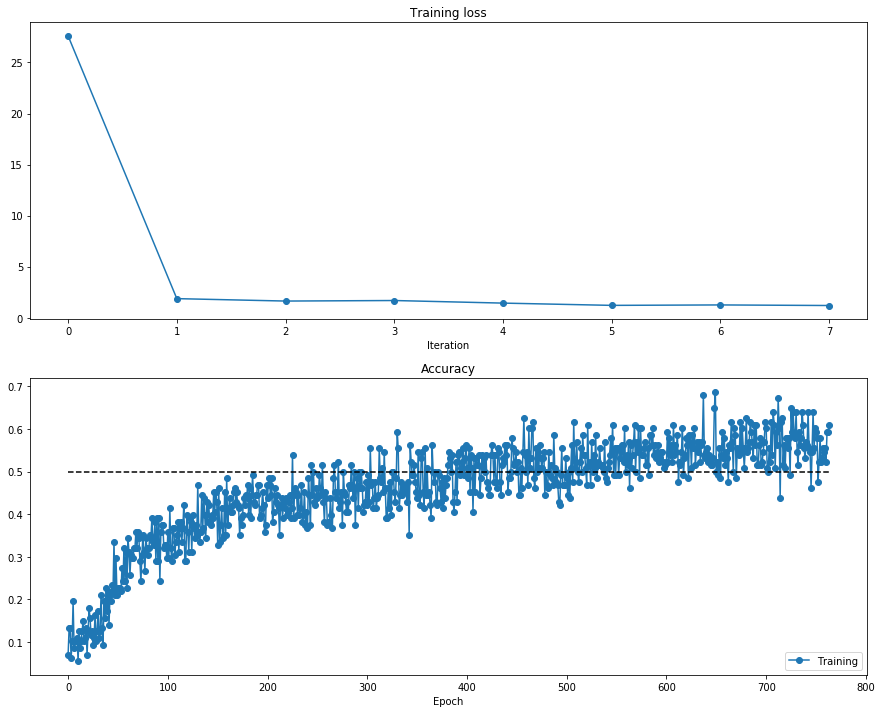

validation for epoch 1
-  epoch 1: validation accuracy = 0.550
train for epoch 2
iteration (800): loss = 1.058, accuracy = 0.648
iteration (850): loss = 1.303, accuracy = 0.500
iteration (900): loss = 1.030, accuracy = 0.648
iteration (950): loss = 0.974, accuracy = 0.664
iteration (1000): loss = 1.062, accuracy = 0.609
iteration (1050): loss = 1.014, accuracy = 0.625
iteration (1100): loss = 1.058, accuracy = 0.648


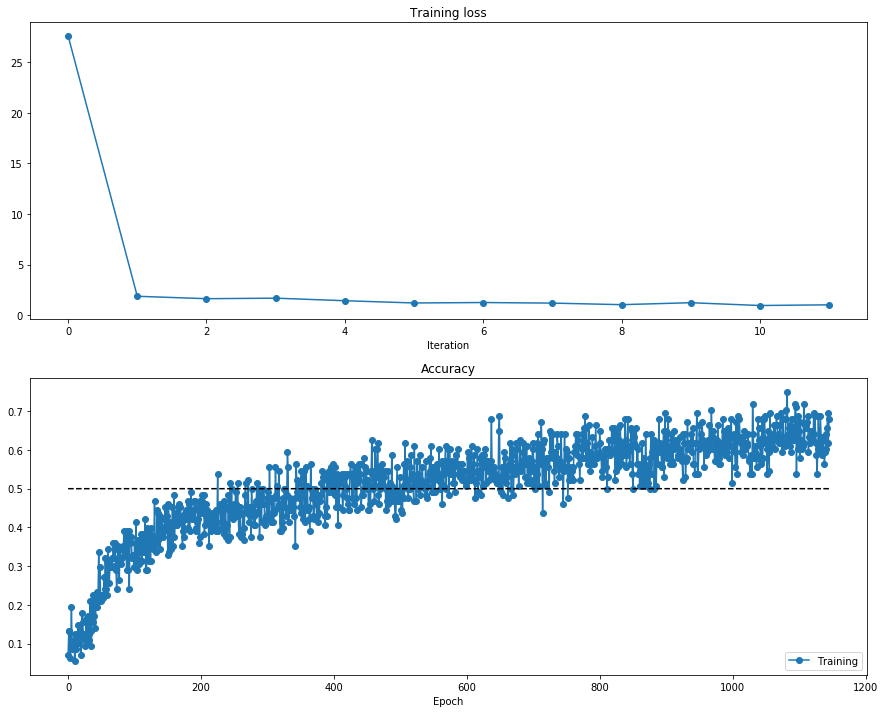

validation for epoch 2
-  epoch 2: validation accuracy = 0.581
train for epoch 3
iteration (1150): loss = 1.035, accuracy = 0.680
iteration (1200): loss = 0.935, accuracy = 0.633
iteration (1250): loss = 1.015, accuracy = 0.664
iteration (1300): loss = 0.995, accuracy = 0.656
iteration (1350): loss = 0.838, accuracy = 0.742
iteration (1400): loss = 0.849, accuracy = 0.695
iteration (1450): loss = 0.835, accuracy = 0.711
iteration (1500): loss = 0.797, accuracy = 0.711


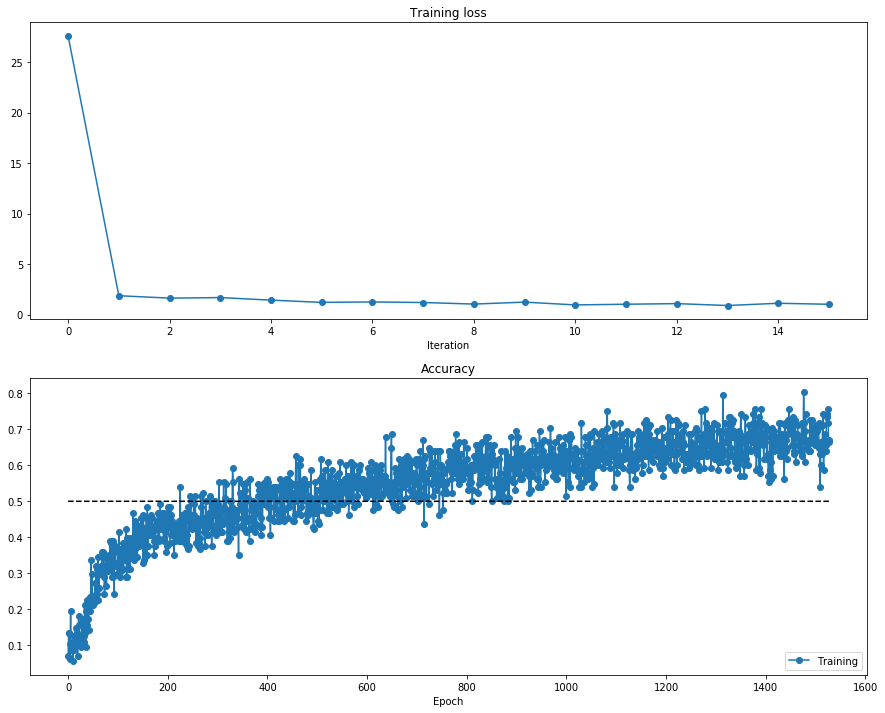

validation for epoch 3
-  epoch 3: validation accuracy = 0.583
train for epoch 4
iteration (1550): loss = 0.886, accuracy = 0.688
iteration (1600): loss = 1.041, accuracy = 0.617
iteration (1650): loss = 0.926, accuracy = 0.727
iteration (1700): loss = 0.897, accuracy = 0.633
iteration (1750): loss = 0.833, accuracy = 0.727
iteration (1800): loss = 0.867, accuracy = 0.703
iteration (1850): loss = 0.940, accuracy = 0.680
iteration (1900): loss = 0.808, accuracy = 0.719


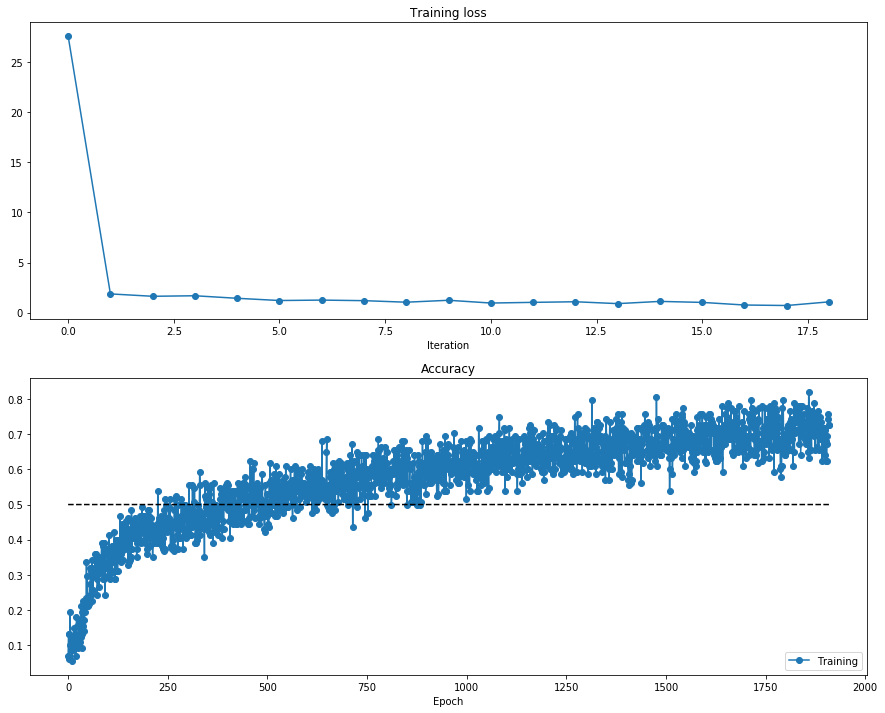

validation for epoch 4
-  epoch 4: validation accuracy = 0.568
***** test accuracy: 0.554


In [34]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [15]:
# Final Working Model with 70% accuracy
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 20
        self.batch_size = 50
    
    # Define max pooling and conv layers
    def conv2d(self, input, kernel_size, stride, num_filter):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
        W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
        
        weight_decay = tf.multiply(tf.nn.l2_loss(W), 0.0, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
        
        return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

    def max_pool(self, input, kernel_size, stride):
        ksize = [1, kernel_size, kernel_size, 1]
        strides = [1, stride, stride, 1]
        return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

    def FC(self, input, inp_neurons, out_neurons):
        #W = tf.get_variable('w',[inp_neurons,out_neurons], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        W = tf.get_variable('w',[inp_neurons,out_neurons], tf.float32, tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [out_neurons], initializer=tf.constant_initializer(0.0))
        
        weight_decay = tf.multiply(tf.nn.l2_loss(W), 0.004, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
        
        return tf.matmul(input, W) + b

    def Normalization(self, input):
        return tf.nn.local_response_normalization(input,
                                                  alpha=0.001 / 9.0,
                                                  beta=0.75,
                                                  depth_radius=4,
                                                  bias=1.0)

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = self.conv2d(self.X, 3, 1, 16)
            self.relu1 = tf.nn.relu(self.conv1)
            self.lnorm1 = self.Normalization(self.relu1)
            self.pool1 = self.max_pool(self.lnorm1, 2, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = self.conv2d(self.pool1, 3, 1, 32)
            self.relu2 = tf.nn.relu(self.conv2)
            self.lnorm2 = self.Normalization(self.relu2)
            self.pool2 = self.max_pool(self.lnorm2, 2, 2)            
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        with tf.variable_scope('conv3'):
            self.conv3 = self.conv2d(self.pool2, 3, 1, 64)
            self.relu3 = tf.nn.relu(self.conv3)
            self.lnorm3 = self.Normalization(self.relu3)
            self.pool3 = self.max_pool(self.lnorm3, 2, 2)   
            print('conv3 layer: ' + str(self.pool3.get_shape()))
            
        
        #############################################################################
        # Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.contrib.layers.flatten(self.pool3)     
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = self.FC(self.flat, self.flat.get_shape()[1], 384)
            self.relu4 = tf.nn.relu(self.fc4)
#             if self.is_train:
#                 self.drop_out4 = tf.nn.dropout(self.relu4, self.keep_prob)
#             else:
#                 self.drop_out4 = self.relu4
            print('fc4 layer: ' + str(self.relu4.get_shape()))
            
        
        with tf.variable_scope('fc5'):
            self.fc5 = self.FC(self.relu4, self.relu4.get_shape()[1], 192)
            self.relu5 = tf.nn.relu(self.fc5)
#             if self.is_train:
#                 self.drop_out5 = tf.nn.dropout(self.relu5, self.keep_prob)
#             else:
#                 self.drop_out5 = self.relu5
            print('fc5 layer: ' + str(self.relu5.get_shape()))
        

        with tf.variable_scope('fc6'):
            self.fc6 = self.FC(self.relu5, self.relu5.get_shape()[1], 10)            
            print('fc6 layer: ' + str(self.fc6.get_shape()))

        return self.fc6

    def _input_ops(self):
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        self.is_train = True
        self.keep_prob = tf.placeholder(tf.float32)


    def _build_optimizer(self):
        self.global_step = tf.Variable(0, trainable=False)
        self.initial_lr = 1e-3
        #self.exp_decay = tf.train.exponential_decay(self.initial_lr, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.initial_lr).minimize(self.loss_op, global_step=self.global_step)

        
    def _loss(self, labels, logits):       
        cross_entropy_mean = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))     
        tf.add_to_collection('losses', cross_entropy_mean)
        self.loss_op = tf.add_n(tf.get_collection('losses'), name='total_loss')


    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
#     def train(self, sess, X_train, Y_train, X_val, Y_val):
#         sess.run(tf.global_variables_initializer())

#         step = 0
#         losses = []
#         accuracies = []
#         print('-' * 5 + '  Start training  ' + '-' * 5)
        
#         self.is_train = True
#         for epoch in range(self.num_epoch):
#             print('train for epoch %d' % epoch)
#             for i in range(num_training // self.batch_size):
#                 X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
#                 Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]


#                 feed_dict = {self.X: X_, self.Y:Y_, self.keep_prob: 0.25}                

#                 fetches = [self.train_op, self.loss_op, self.accuracy_op]

#                 _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
#                 losses.append(loss)
#                 accuracies.append(accuracy)
#                 if step % self.log_step == 0:
#                     print('iteration (%d): loss = %.3f, accuracy = %.3f' %
#                         (step, loss, accuracy))
#                 step += 1



#             # Print validation results
#             self.is_train = False
#             print('validation for epoch %d' % epoch)
#             val_accuracy = self.evaluate(sess, X_val, Y_val)
#             print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
#             self.is_train = True

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        

            feed_dict = {self.X:X_, self.Y:Y_, self.keep_prob: 0.2}

            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 16)
conv2 layer: (?, 8, 8, 32)
conv3 layer: (?, 4, 4, 64)
flat layer: (?, 1024)
fc4 layer: (?, 384)
fc5 layer: (?, 192)
fc6 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 15.132, accuracy = 0.140
iteration (50): loss = 3.493, accuracy = 0.220
iteration (100): loss = 3.007, accuracy = 0.420
iteration (150): loss = 2.749, accuracy = 0.520
iteration (200): loss = 2.731, accuracy = 0.420
iteration (250): loss = 2.670, accuracy = 0.480
iteration (300): loss = 2.583, accuracy = 0.360
iteration (350): loss = 2.383, accuracy = 0.540
iteration (400): loss = 2.627, accuracy = 0.360
iteration (450): loss = 2.357, accuracy = 0.480
iteration (500): loss = 2.094, accuracy = 0.560
iteration (550): loss = 2.345, accuracy = 0.460
iteration (600): loss = 2.120, accuracy = 0.580
iteration (650): loss = 2.171, accuracy = 0.520
iteration (700): loss = 1.890, accuracy = 0.520
iteration (750)

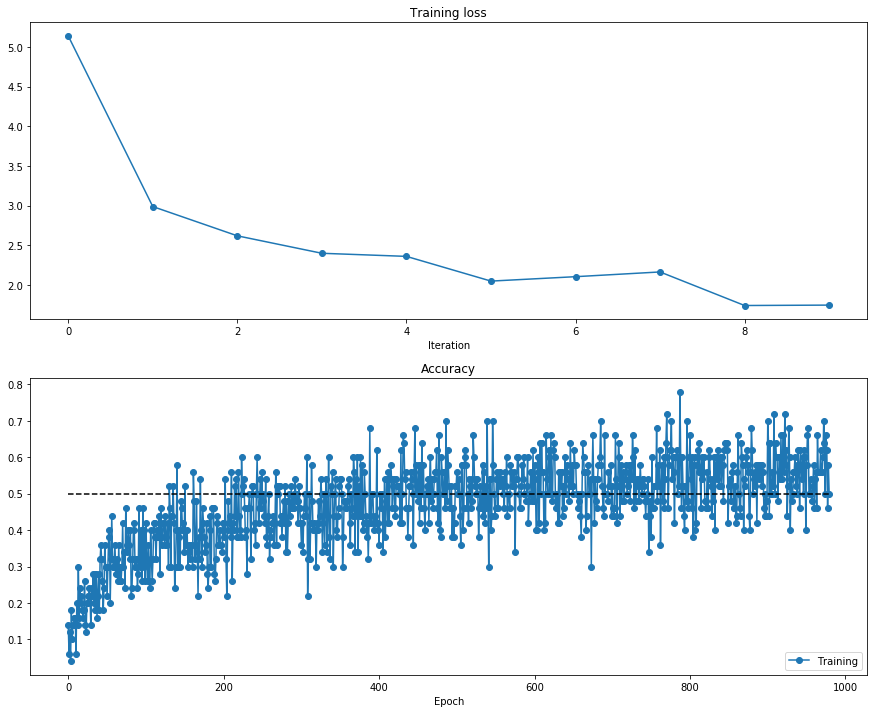

validation for epoch 0
-  epoch 0: validation accuracy = 0.561
train for epoch 1
iteration (1000): loss = 1.747, accuracy = 0.500
iteration (1050): loss = 1.543, accuracy = 0.620
iteration (1100): loss = 1.721, accuracy = 0.540
iteration (1150): loss = 1.664, accuracy = 0.660
iteration (1200): loss = 1.940, accuracy = 0.520
iteration (1250): loss = 1.636, accuracy = 0.620
iteration (1300): loss = 1.502, accuracy = 0.620
iteration (1350): loss = 1.428, accuracy = 0.620
iteration (1400): loss = 1.576, accuracy = 0.680
iteration (1450): loss = 1.646, accuracy = 0.580
iteration (1500): loss = 1.275, accuracy = 0.720
iteration (1550): loss = 1.526, accuracy = 0.620
iteration (1600): loss = 1.764, accuracy = 0.560
iteration (1650): loss = 1.793, accuracy = 0.560
iteration (1700): loss = 1.442, accuracy = 0.600
iteration (1750): loss = 1.206, accuracy = 0.820
iteration (1800): loss = 1.493, accuracy = 0.620
iteration (1850): loss = 1.381, accuracy = 0.620
iteration (1900): loss = 1.271, accur

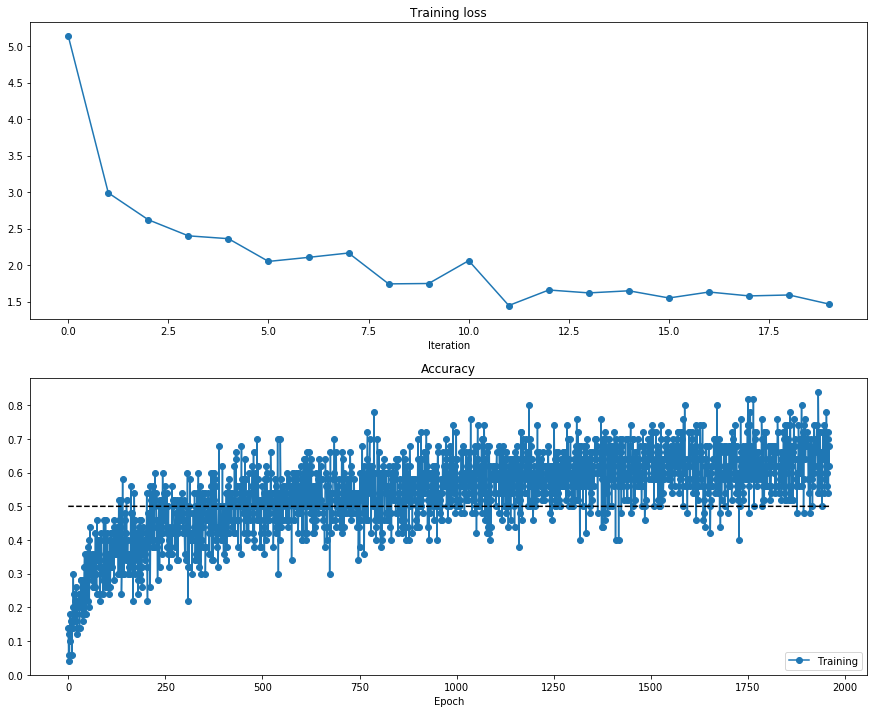

validation for epoch 1
-  epoch 1: validation accuracy = 0.633
train for epoch 2
iteration (2000): loss = 1.729, accuracy = 0.540
iteration (2050): loss = 1.286, accuracy = 0.680
iteration (2100): loss = 1.306, accuracy = 0.680
iteration (2150): loss = 0.985, accuracy = 0.720
iteration (2200): loss = 1.143, accuracy = 0.800
iteration (2250): loss = 1.237, accuracy = 0.640
iteration (2300): loss = 1.024, accuracy = 0.740
iteration (2350): loss = 1.229, accuracy = 0.700
iteration (2400): loss = 1.237, accuracy = 0.680
iteration (2450): loss = 1.168, accuracy = 0.680
iteration (2500): loss = 1.212, accuracy = 0.700
iteration (2550): loss = 0.995, accuracy = 0.780
iteration (2600): loss = 1.302, accuracy = 0.660
iteration (2650): loss = 0.954, accuracy = 0.800
iteration (2700): loss = 1.067, accuracy = 0.760
iteration (2750): loss = 1.013, accuracy = 0.800
iteration (2800): loss = 1.202, accuracy = 0.700
iteration (2850): loss = 1.093, accuracy = 0.660
iteration (2900): loss = 1.079, accur

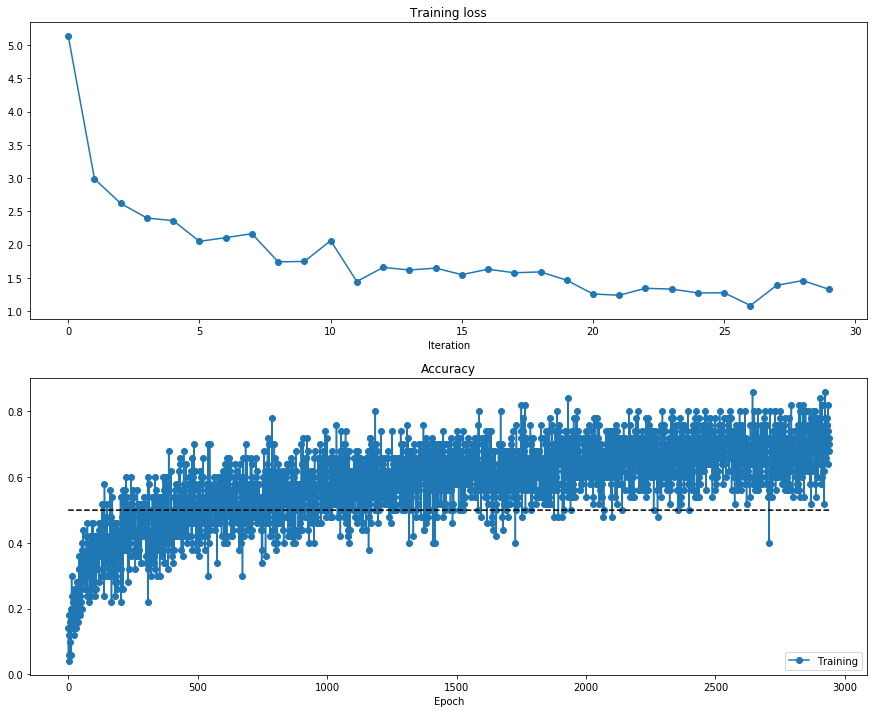

validation for epoch 2
-  epoch 2: validation accuracy = 0.676
train for epoch 3
iteration (2950): loss = 0.875, accuracy = 0.780
iteration (3000): loss = 1.067, accuracy = 0.740
iteration (3050): loss = 1.110, accuracy = 0.720
iteration (3100): loss = 1.026, accuracy = 0.760
iteration (3150): loss = 0.917, accuracy = 0.800
iteration (3200): loss = 1.225, accuracy = 0.600
iteration (3250): loss = 0.989, accuracy = 0.700
iteration (3300): loss = 1.446, accuracy = 0.660
iteration (3350): loss = 0.884, accuracy = 0.780
iteration (3400): loss = 0.910, accuracy = 0.800
iteration (3450): loss = 1.000, accuracy = 0.740
iteration (3500): loss = 0.879, accuracy = 0.800
iteration (3550): loss = 1.237, accuracy = 0.680
iteration (3600): loss = 1.365, accuracy = 0.560
iteration (3650): loss = 0.957, accuracy = 0.680
iteration (3700): loss = 1.098, accuracy = 0.620
iteration (3750): loss = 0.867, accuracy = 0.780
iteration (3800): loss = 1.233, accuracy = 0.600
iteration (3850): loss = 0.911, accur

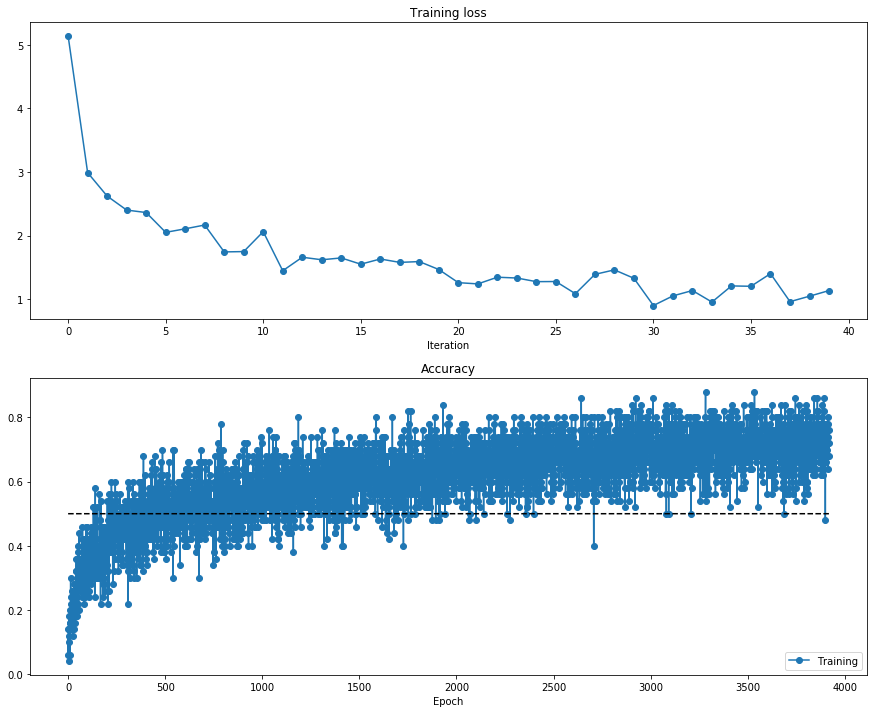

validation for epoch 3
-  epoch 3: validation accuracy = 0.695
train for epoch 4
iteration (3950): loss = 1.146, accuracy = 0.600
iteration (4000): loss = 0.981, accuracy = 0.660
iteration (4050): loss = 0.750, accuracy = 0.860
iteration (4100): loss = 1.329, accuracy = 0.620
iteration (4150): loss = 0.975, accuracy = 0.620
iteration (4200): loss = 1.156, accuracy = 0.580
iteration (4250): loss = 0.986, accuracy = 0.700
iteration (4300): loss = 0.929, accuracy = 0.720
iteration (4350): loss = 1.215, accuracy = 0.680
iteration (4400): loss = 0.774, accuracy = 0.800
iteration (4450): loss = 0.992, accuracy = 0.700
iteration (4500): loss = 0.953, accuracy = 0.740
iteration (4550): loss = 0.799, accuracy = 0.820
iteration (4600): loss = 0.927, accuracy = 0.780
iteration (4650): loss = 1.084, accuracy = 0.740
iteration (4700): loss = 0.871, accuracy = 0.740
iteration (4750): loss = 0.969, accuracy = 0.740
iteration (4800): loss = 0.977, accuracy = 0.720
iteration (4850): loss = 1.059, accur

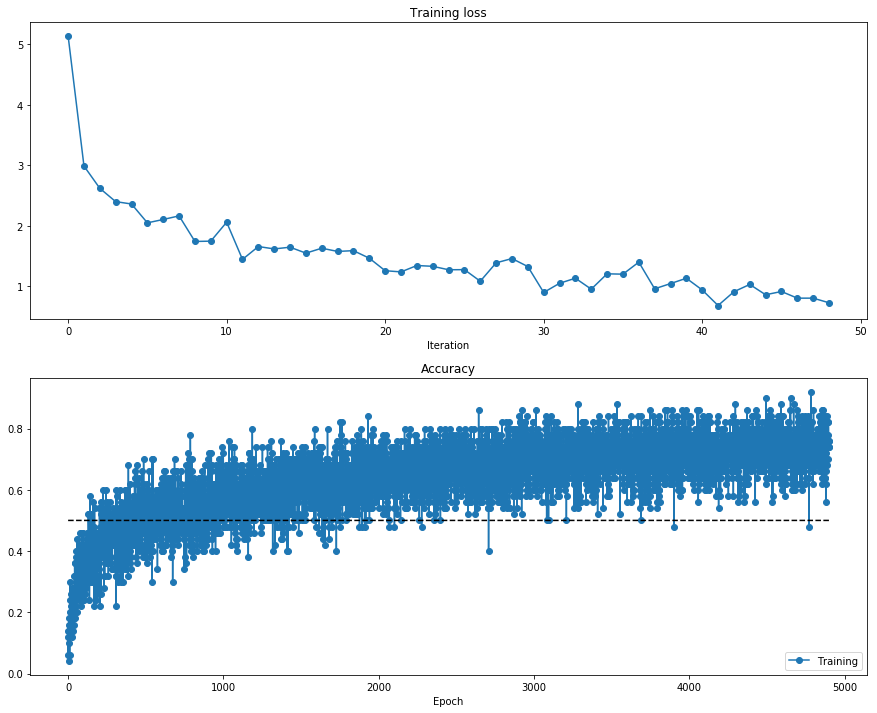

validation for epoch 4
-  epoch 4: validation accuracy = 0.706
train for epoch 5
iteration (4900): loss = 0.999, accuracy = 0.720
iteration (4950): loss = 0.700, accuracy = 0.860
iteration (5000): loss = 0.858, accuracy = 0.760
iteration (5050): loss = 0.899, accuracy = 0.680
iteration (5100): loss = 0.994, accuracy = 0.660
iteration (5150): loss = 1.123, accuracy = 0.680
iteration (5200): loss = 0.802, accuracy = 0.780
iteration (5250): loss = 0.886, accuracy = 0.780
iteration (5300): loss = 1.087, accuracy = 0.700
iteration (5350): loss = 0.927, accuracy = 0.720
iteration (5400): loss = 0.618, accuracy = 0.880
iteration (5450): loss = 0.981, accuracy = 0.720
iteration (5500): loss = 0.804, accuracy = 0.840
iteration (5550): loss = 0.932, accuracy = 0.760
iteration (5600): loss = 0.857, accuracy = 0.800
iteration (5650): loss = 1.214, accuracy = 0.620
iteration (5700): loss = 0.883, accuracy = 0.740
iteration (5750): loss = 1.340, accuracy = 0.560
iteration (5800): loss = 0.774, accur

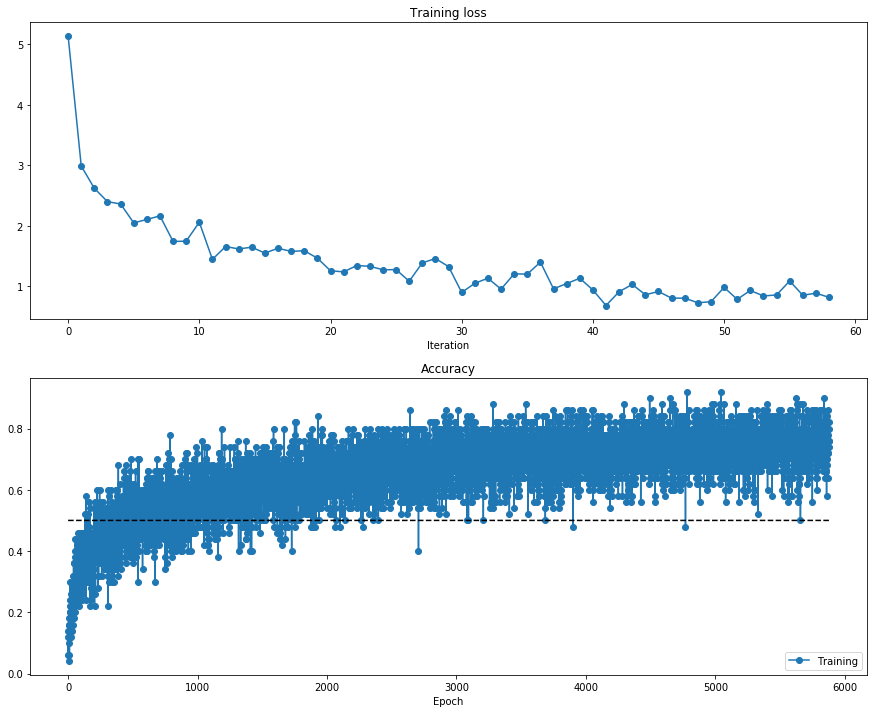

validation for epoch 5
-  epoch 5: validation accuracy = 0.698
train for epoch 6
iteration (5900): loss = 1.080, accuracy = 0.680
iteration (5950): loss = 0.927, accuracy = 0.760
iteration (6000): loss = 0.904, accuracy = 0.660
iteration (6050): loss = 0.867, accuracy = 0.800
iteration (6100): loss = 0.883, accuracy = 0.760
iteration (6150): loss = 0.844, accuracy = 0.800
iteration (6200): loss = 0.831, accuracy = 0.840
iteration (6250): loss = 0.679, accuracy = 0.820
iteration (6300): loss = 0.841, accuracy = 0.760
iteration (6350): loss = 0.998, accuracy = 0.700
iteration (6400): loss = 0.739, accuracy = 0.860
iteration (6450): loss = 1.149, accuracy = 0.680
iteration (6500): loss = 0.846, accuracy = 0.740
iteration (6550): loss = 1.238, accuracy = 0.660
iteration (6600): loss = 0.972, accuracy = 0.780
iteration (6650): loss = 0.730, accuracy = 0.780
iteration (6700): loss = 1.002, accuracy = 0.760
iteration (6750): loss = 0.801, accuracy = 0.760
iteration (6800): loss = 0.775, accur

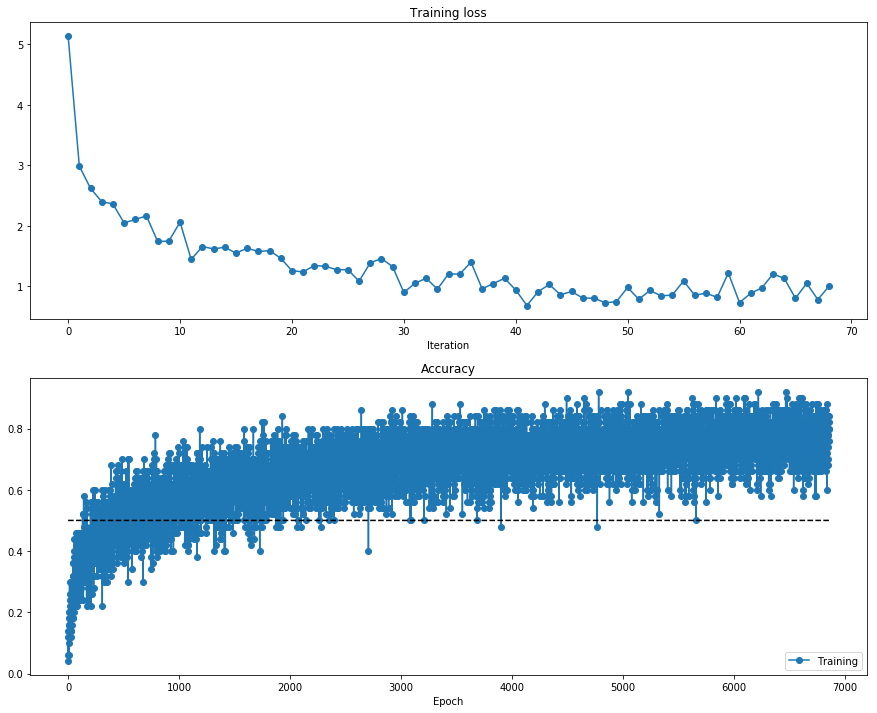

validation for epoch 6
-  epoch 6: validation accuracy = 0.710
train for epoch 7
iteration (6900): loss = 1.124, accuracy = 0.680
iteration (6950): loss = 0.890, accuracy = 0.800
iteration (7000): loss = 0.954, accuracy = 0.740
iteration (7050): loss = 0.692, accuracy = 0.800
iteration (7100): loss = 0.762, accuracy = 0.800
iteration (7150): loss = 0.698, accuracy = 0.820
iteration (7200): loss = 0.824, accuracy = 0.780
iteration (7250): loss = 0.859, accuracy = 0.740
iteration (7300): loss = 0.961, accuracy = 0.760
iteration (7350): loss = 0.826, accuracy = 0.760
iteration (7400): loss = 1.062, accuracy = 0.800
iteration (7450): loss = 0.868, accuracy = 0.840
iteration (7500): loss = 0.958, accuracy = 0.780
iteration (7550): loss = 0.791, accuracy = 0.840
iteration (7600): loss = 0.965, accuracy = 0.740
iteration (7650): loss = 0.761, accuracy = 0.780
iteration (7700): loss = 0.811, accuracy = 0.840
iteration (7750): loss = 0.704, accuracy = 0.840
iteration (7800): loss = 0.863, accur

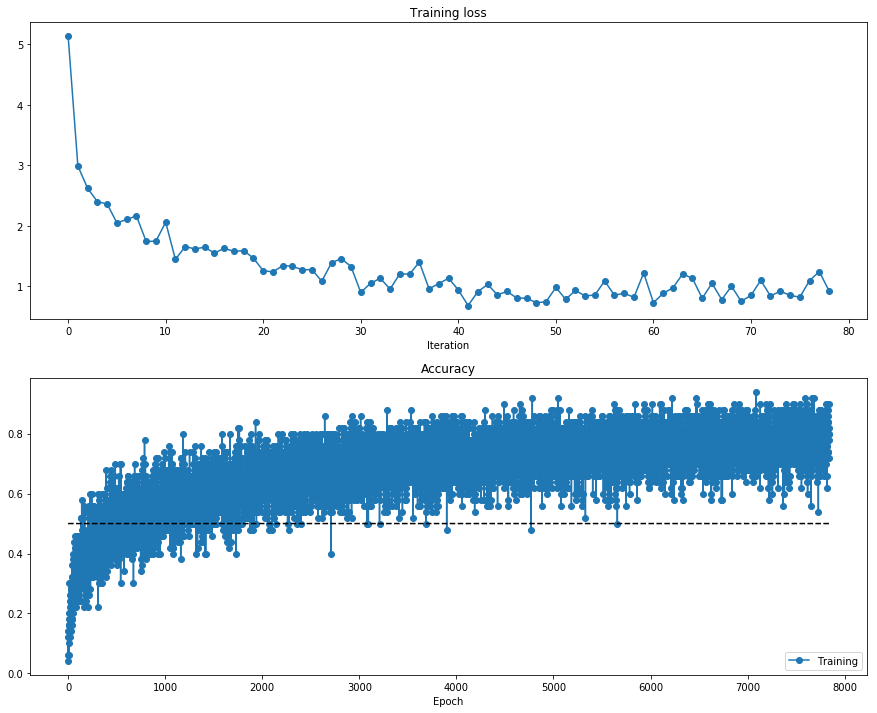

validation for epoch 7
-  epoch 7: validation accuracy = 0.715
train for epoch 8
iteration (7850): loss = 0.567, accuracy = 0.880
iteration (7900): loss = 0.900, accuracy = 0.820
iteration (7950): loss = 0.835, accuracy = 0.740
iteration (8000): loss = 0.709, accuracy = 0.840
iteration (8050): loss = 0.672, accuracy = 0.860
iteration (8100): loss = 0.925, accuracy = 0.700
iteration (8150): loss = 0.800, accuracy = 0.820
iteration (8200): loss = 1.044, accuracy = 0.700
iteration (8250): loss = 0.756, accuracy = 0.820
iteration (8300): loss = 0.688, accuracy = 0.840
iteration (8350): loss = 0.639, accuracy = 0.900
iteration (8400): loss = 0.792, accuracy = 0.720
iteration (8450): loss = 1.127, accuracy = 0.800
iteration (8500): loss = 0.936, accuracy = 0.700
iteration (8550): loss = 0.616, accuracy = 0.860
iteration (8600): loss = 1.070, accuracy = 0.700
iteration (8650): loss = 0.925, accuracy = 0.720
iteration (8700): loss = 0.911, accuracy = 0.720
iteration (8750): loss = 0.722, accur

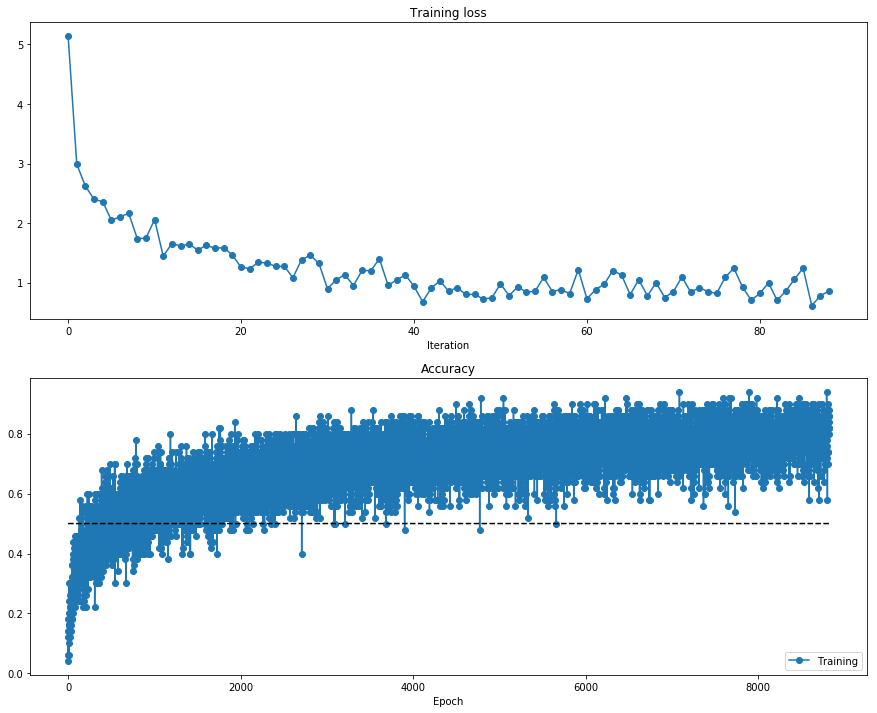

validation for epoch 8
-  epoch 8: validation accuracy = 0.717
train for epoch 9
iteration (8850): loss = 0.967, accuracy = 0.780
iteration (8900): loss = 0.857, accuracy = 0.800
iteration (8950): loss = 0.662, accuracy = 0.920
iteration (9000): loss = 1.003, accuracy = 0.680
iteration (9050): loss = 0.860, accuracy = 0.760
iteration (9100): loss = 0.815, accuracy = 0.740
iteration (9150): loss = 0.739, accuracy = 0.840
iteration (9200): loss = 0.794, accuracy = 0.800
iteration (9250): loss = 1.005, accuracy = 0.760
iteration (9300): loss = 0.653, accuracy = 0.840
iteration (9350): loss = 0.975, accuracy = 0.680
iteration (9400): loss = 0.926, accuracy = 0.680
iteration (9450): loss = 0.608, accuracy = 0.860
iteration (9500): loss = 0.909, accuracy = 0.740
iteration (9550): loss = 0.821, accuracy = 0.760
iteration (9600): loss = 0.667, accuracy = 0.880
iteration (9650): loss = 0.857, accuracy = 0.760
iteration (9700): loss = 0.697, accuracy = 0.880
iteration (9750): loss = 0.890, accur

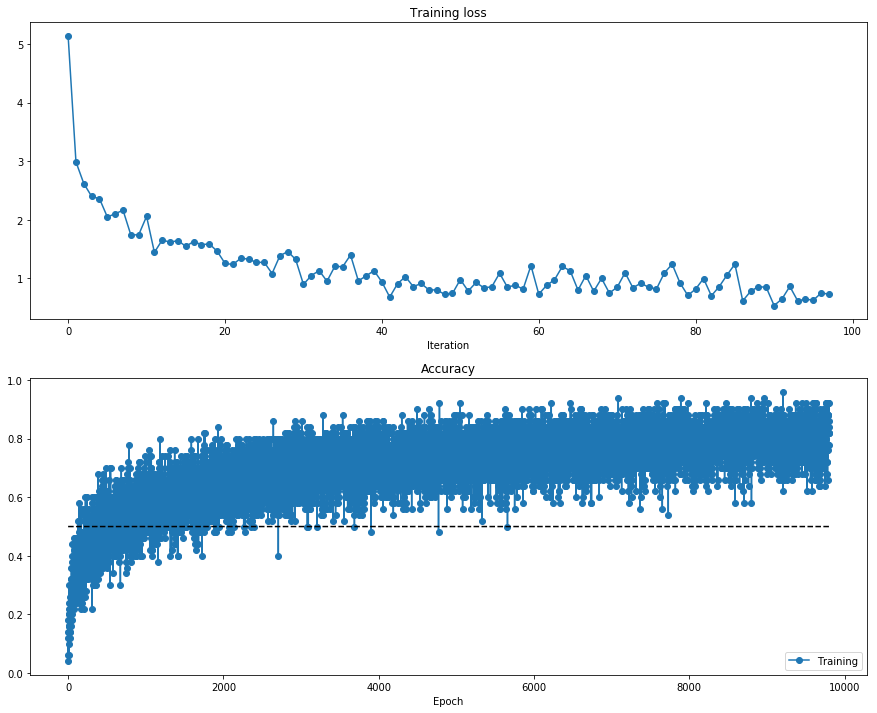

validation for epoch 9
-  epoch 9: validation accuracy = 0.719
***** test accuracy: 0.703
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [33]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# Preprocessing                                                       #
#############################################################################
# X_train_ = X_train
# X_val_ = X_val
# X_test_ = X_test

# Mean Subtraction
X_train_ = X_train.astype(np.float64)
X_val_ = X_val.astype(np.float64)
X_test_ = X_test.astype(np.float64)

X_train_ -= np.mean(X_train)
X_val_ -= np.mean(X_val)
X_test_ -= np.mean(X_test)


# Data Augmentation
# images = tf.convert_to_tensor(X_train)
# scaled_images = tf.image.resize_images(images, [32,32])
# distorted_images=tf.image.resize_image_with_crop_or_pad(images,32,32)
# distorted_images = tf.image.random_brightness(distorted_images,
#                                                max_delta=63)
# distorted_images = tf.image.random_contrast(distorted_images,
#                                              lower=0.2, upper=1.8)

# s1 = tf.Session()
# with s1.as_default():
#     aug_data = s1.run(distorted_images)
#     scaled_train = s1.run(scaled_images)
# s1.close()
# aug_train = np.append(scaled_train, aug_data, axis=0)
# aug_label = np.append(Y_train,Y_train, axis=0)
# rand = np.random.permutation(aug_train.shape[0])
# X_train_ = aug_train[rand]
# Y_train_ = aug_label[rand]

# del images, scaled_images, distorted_images, aug_data, scaled_train, aug_train, aug_label


model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
model.is_train = False
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [44]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 16)
conv2 layer: (?, 8, 8, 32)
conv3 layer: (?, 4, 4, 64)
flat layer: (?, 1024)
fc4 layer: (?, 384)
fc5 layer: (?, 192)
fc6 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
